In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline
import math
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (test_x, test_y) = cifar10.load_data()

num_classes = 10
y_train_cls = np_utils.to_categorical(y_train,num_classes)
test_y_cls = np_utils.to_categorical(test_y,num_classes)

print("Size of:")
print("- Training-set:\t\t{}".format(len(x_train)))
print("- Test-set:\t\t{}".format(len(test_x)))

Size of:
- Training-set:		50000
- Test-set:		10000


In [12]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

class_names = load_label_names()

def label_to_array(cls_true):
    true = cls_true.tolist()
    true_label = []
    for l in true:
        true_label += l
    return true_label
    

(50000, 32, 32, 3)
(50000, 10)


In [3]:
#Data Dimensions

# CIFAR-10 images are 32 pixels in each dimension.
img_size = 32

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images:
num_channels = 3

# Number of classes, one class for each of 10 digits.
num_classes = 10

input_shape = (img_size, img_size, num_channels)

In [14]:
#Plotting Images

def plot_images(images, cls_true, cls_pred=None, smooth=True):

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
# Split data into train and validation sets
from sklearn.model_selection import train_test_split


train_x, validation_x, train_y, validation_y = train_test_split(x_train, y_train_cls,
                                                                test_size=0.2, random_state=42)

In [23]:
#Preparing Data
def data_prep(train, validation,test, subtract_pixel_mean):
    # Normalize Data
    train = train.astype('float32')/255
    validation = validation.astype('float32')/255
    test = test.astype('float32')/255
    
    # If subtract pixel mean is enabled
    if subtract_pixel_mean:
        train_mean = np.mean(train, axis=0)
        train -= train_mean
        validation -= train_mean
        test -= train_mean
        
    return train, validation, test


In [ ]:
# Subtract per pixel
subtract_pixel_mean = True

train_x, validation_x, test_x = data_prep(train_x, validation_x, test_x, subtract_pixel_mean)

## Data Augmentation

In [15]:
from keras.preprocessing.image import ImageDataGenerator

def augment_batches(batch_size, data):
    '''
    Return a total of `num` samples
    '''
    
    images=batch_size
    while(images + batch_size <= len(data)):
        prev_no = images
        images += batch_size
        data[prev_no:images] = crop_images(data[prev_no:images])
    
    return data


# Padding images to 36x36 then randomly crop 32x32 size images
def crop_images(train):
    
    # Zero pad images to 36x36 size
    train = tf.image.resize_with_crop_or_pad(train,
                                             target_height=36,
                                             target_width=36).numpy()
    train = tf.image.random_crop(train, size=[train.shape[0], 32, 32, 3])
    
    return train.numpy()
    

In [16]:
## Random crop images
random_crop = False

if (random_crop):
    train_x, train_y = crop_images(train_x, train_y, 50000)

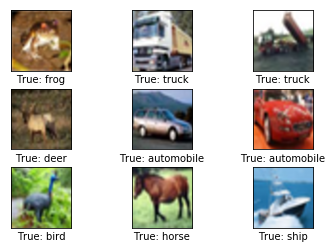

In [17]:
# Get the first 9 images from the test-set.
images = train_x[0:9]

# Get the true classes for those images.
cls_true = train_y[0:9]
cls_true = label_to_array(cls_true)

# Plot the images and labels using our helper-function above.
plot_images(images, cls_true)


### Import Required Libraries

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D, Add
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import SGD

## BottleNeck Block

### Define a BottleNeck Block
For each residual function F, we use a stack of 3 layers. The three layers are 1×1, 3×3, and 1×1 convolutions, where the 1×1 layers are responsible for reducing and then increasing (restoring) dimensions, leaving the 3×3 layer a bottleneck with smaller input/output dimensions.

#### Structure of a BottleNeck Block is given below
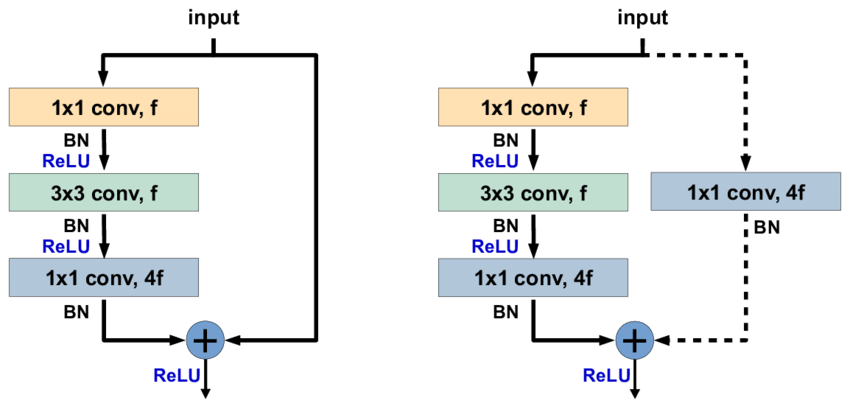

In [5]:
def bottleneck_block(net, shape, filters, stage, block, s=1):
    '''
    Arguments: 
    1. net -- input tensor of shape(m, h_prev, w_prev, c_prev)
    2. shape -- integer, specifying the shape of the middle CONV's
    window for the main path
    3. filters -- list of integers, defining the no of filters of 
    CONV layers in the main path
    4. stage -- integer, used to name the layers depending on their 
    position in the network
    5. block -- string/character used to name the layers depending
    on their position in the network
    6. s -- Integer specifying the stride to be used
    
    Returns:
    net -- output of the identity block, tensor of shape
    (h_curr, w_curr, c_curr)
    '''
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + str(block) + '_branch'
    bn_name_base = 'bn' + str(stage) + str(block) + '_branch'
    
    # Retrieve filters
    # we are using three conv layers
    F1, F2, F3 = filters
    
    # Save input value to be used as shortcut to add to main path
    net_shortcut = net
    
    ## Main Path
    # First component
    net = Conv2D(filters=F1, kernel_size=(1,1),
                 name = conv_name_base + '2a',
                 strides=(s,s), padding='same')(net)
    net = BatchNormalization(axis = 3, name = bn_name_base + '2a')(net)
    net = Activation('relu')(net)
    
    ## Second component
    net = Conv2D(filters=F2, kernel_size=(shape,shape),
                 name = conv_name_base + '2b',
                 strides=(1,1), padding='same')(net)
    net = BatchNormalization(axis = 3, name = bn_name_base + '2b')(net)
    net = Activation('relu')(net)
    
    ## Third Path
    net = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1),
                         padding='same',
                         name = conv_name_base + '2c')(net)
    
    ## Shortcut Path
    net_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s),
                         padding='same',
                         name = conv_name_base + '1')(net_shortcut)
    net_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(net_shortcut)
    
    # Final step: Add shortcut value to main path, 
    # and pass it through a RELU activation
    
    net = Add()([net, net_shortcut])
    net = Activation('relu')(net)
    
    return net

## Create ResNet Model

In [10]:
## ResNet
def ResNet(input_shape, depth, num_classes):
    """
    Implementation of the ResNet50 having the following architecture:
    CONV2D -> BATCHNORM -> RELU -> BNBLOCK*3 -> 
    BNBLOCK*4 -> BNBLOCK*6 -> BNBLOCK*3 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    depth -- num of convolutional layers in the network( including first and last layers)
    classes -- integer, number of classes
    
    NOTE: Assuming all stages contain the same no of blocks 
          Total Layers = 9n+2 (each stage containing 3n layers)
    
    Returns:
    model -- a Model() instance in Keras
    """
    # Define a tensor with input shape
    inputs = Input(input_shape)
    
    # Stage 1 --> 3x3 Convolution with 16 filters and stride 1
    net = Conv2D(16, (3,3), strides=(1,1), padding='same',
                name='conv1')(inputs)
    net = BatchNormalization(axis=3, name='bn_conv1')(net)
    net = Activation('relu')(net)
    
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg. 56 or 110')
    
    num_filters = 16
    num_blocks = int((depth-2)/9)
    
    for stage in range(3):
        block=0
        while block < num_blocks:
            
            if stage > 0 and block==0: # first layer but not first stage
                # Downsampling is done
                net = bottleneck_block(net, shape=3, 
                                       filters=[num_filters,num_filters,num_filters*4],
                                       stage=stage, block=block, s=2)
                block+=1
                
            net = bottleneck_block(net, shape=3, filters=[num_filters,num_filters,num_filters*4],
                                   stage=stage, block=block)
            block+=1
            
        num_filters*=2
    
    # Global Average Pooling
    net = AveragePooling2D((2,2), name="avg_pool")(net)
    
    # Flatten Layer
    net = Flatten()(net)
    
    # Output Layer
    net = Dense(num_classes, activation='softmax', name='fc')(net)
    
    # Create Model
    model = Model(inputs=inputs, outputs=net, name='ResNet50')
    
    return model
    
    

In [11]:
# Creating Model
model = ResNet(input_shape, 56, num_classes)

In [56]:
num_epochs = 50

# Initialize the optimizer and compile the model
optimizer = SGD(lr=0.0, momentum=0.9, decay=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer,
             metrics=['accuracy'])


## Step Decay
By using step decay, we schedule drop the learning rate by a factor every few epochs.

#### Is useful when training for long epochs

In [ ]:
# Define step decay function
class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = num_epochs/2
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate

# learning schedule callback
loss_history = LossHistory()
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]

In [12]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 16)   64          conv1[0][0]                      
__________________________________________________________________________________________________
activation_55 (Activation)      (None, 32, 32, 16)   0           bn_conv1[0][0]                   
___________________________________________________________________________________________

### Training the Model

In [ ]:
# Use Data Augmentation or not
augment_data = True

In [ ]:
# Run training, with or without data augmentation.
if not augment_data:
    print('Not using data augmentation.')
    h = model.fit(train_x,
                  train_y,
                  batch_size = 128,
                  validation_data = (validation_x, validation_y),
                  callbacks=callbacks_list, 
                  epochs = num_epochs,
                  verbose = 1)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.2)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_x)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(train_x, train_y, batch_size=128),
                        epochs=num_epochs, verbose=1, workers=4,
                        validation_data = (validation_x, validation_y),
                        callbacks=callbacks_list)

In [ ]:
result = model.evaluate(test_x, test_y_cls)

In [ ]:
#Predict on test_set
pred_y = model.predict(test_x)
pred_cls = np.argmax(pred_y, axis=1)

In [ ]:
#Some predicted Images
# Get the first 9 images from the test-set.
images = test_x[0:9]

# Get the true classes for those images.
cls_true = test_y[0:9]
cls_true = label_to_array(cls_true)

#Get Predicted Classes
cls_pred = pred_cls[0:9]
cls_pred = cls_pred.tolist()

# Plot the images and labels using our helper-function above.
plot_images(images, cls_true, cls_pred)